In [1]:
# Full implementation of "Attention Is All You Need" (Transformer) from scratch
# PyTorch implementation for educational & research purposes
# Author: ChatGPT

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

############################################
# 1. Scaled Dot-Product Attention
############################################
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        output = torch.matmul(attn, V)
        return output, attn

############################################
# 2. Multi-Head Attention
############################################
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention(dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)

        Q = self.W_q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)

        x, attn = self.attention(Q, K, V, mask)

        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        return self.W_o(x)

############################################
# 3. Position-wise Feed Forward Network
############################################
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

############################################
# 4. Positional Encoding
############################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

############################################
# 5. Encoder Layer
############################################
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None):
        x2 = self.self_attn(x, x, x, src_mask)
        x = self.norm1(x + self.dropout(x2))
        x2 = self.ffn(x)
        x = self.norm2(x + self.dropout(x2))
        return x

############################################
# 6. Decoder Layer
############################################
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.enc_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, tgt_mask=None, src_mask=None):
        x2 = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(x2))
        x2 = self.enc_attn(x, enc_out, enc_out, src_mask)
        x = self.norm2(x + self.dropout(x2))
        x2 = self.ffn(x)
        x = self.norm3(x + self.dropout(x2))
        return x

############################################
# 7. Encoder & Decoder Stacks
############################################
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

    def forward(self, x, mask=None):
        x = self.pe(self.embed(x))
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.pe = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x, enc_out, tgt_mask=None, src_mask=None):
        x = self.pe(self.embed(x))
        for layer in self.layers:
            x = layer(x, enc_out, tgt_mask, src_mask)
        return self.fc(x)

############################################
# 8. Full Transformer Model
############################################
class Transformer(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model=512, n_layers=6,
                 n_heads=8, d_ff=2048, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, n_layers, n_heads, d_ff, dropout)
        self.decoder = Decoder(tgt_vocab, d_model, n_layers, n_heads, d_ff, dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_out = self.encoder(src, src_mask)
        output = self.decoder(tgt, enc_out, tgt_mask, src_mask)
        return output

############################################
# 9. Example Usage
############################################
if __name__ == '__main__':
    src_vocab = tgt_vocab = 10000
    model = Transformer(src_vocab, tgt_vocab)
    src = torch.randint(0, src_vocab, (2, 20))
    tgt = torch.randint(0, tgt_vocab, (2, 15))
    out = model(src, tgt)
    print(out.shape)  # (batch, tgt_len, vocab)


torch.Size([2, 15, 10000])


Epoch 1: Train=3.9114, Val=3.8080
Epoch 2: Train=3.6286, Val=3.4446
Epoch 3: Train=3.0471, Val=2.7251
Epoch 4: Train=1.9810, Val=1.2396
Epoch 5: Train=0.4404, Val=0.1217
Epoch 6: Train=0.0707, Val=0.0532
Epoch 7: Train=0.0398, Val=0.0355
Epoch 8: Train=0.0283, Val=0.0263
Epoch 9: Train=0.0216, Val=0.0206
Epoch 10: Train=0.0173, Val=0.0167
Epoch 11: Train=0.0142, Val=0.0139
Epoch 12: Train=0.0120, Val=0.0118
Epoch 13: Train=0.0103, Val=0.0102
Epoch 14: Train=0.0089, Val=0.0089
Epoch 15: Train=0.0079, Val=0.0079
Epoch 16: Train=0.0070, Val=0.0070
Epoch 17: Train=0.0062, Val=0.0063
Epoch 18: Train=0.0056, Val=0.0056
Epoch 19: Train=0.0051, Val=0.0051
Epoch 20: Train=0.0046, Val=0.0047


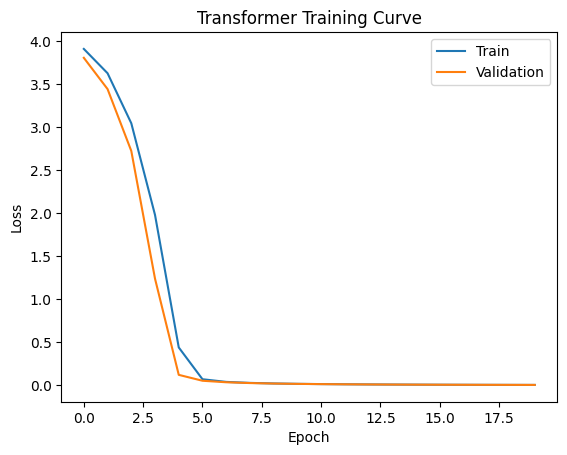

Input: [5, 9, 12, 7, 3, 8, 6, 4, 10, 11]
Prediction: [11, 10, 4, 6, 8, 3, 7, 12, 9, 5]


In [2]:
# FULL TRANSFORMER IMPLEMENTATION WITH DATASET, TRAINING, VALIDATION, LOSS CURVES & INFERENCE
# Based on: "Attention Is All You Need" (Vaswani et al., 2017)
# Framework: PyTorch
# Level: End-to-end (architecture + data + training + inference)

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

############################################
# 1. Toy Translation Dataset (SRC → TGT)
############################################
class ToyTranslationDataset(Dataset):
    """
    Simple synthetic dataset for demonstration
    src = random integers, tgt = reversed src
    """
    def __init__(self, vocab_size=50, seq_len=10, size=2000):
        self.data = []
        for _ in range(size):
            src = torch.randint(2, vocab_size, (seq_len,))
            tgt = torch.flip(src, dims=[0])
            self.data.append((src, tgt))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

############################################
# 2. Attention Components
############################################
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = torch.softmax(scores, dim=-1)
        return torch.matmul(attn, V)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, heads):
        super().__init__()
        self.d_k = d_model // heads
        self.h = heads
        self.qkv = nn.Linear(d_model, d_model * 3)
        self.fc = nn.Linear(d_model, d_model)

    def forward(self, x):
        B, T, D = x.shape
        qkv = self.qkv(x).reshape(B, T, self.h, 3 * self.d_k)
        Q, K, V = qkv.chunk(3, dim=-1)
        Q, K, V = Q.transpose(1,2), K.transpose(1,2), V.transpose(1,2)
        out = ScaledDotProductAttention()(Q, K, V)
        out = out.transpose(1,2).contiguous().view(B, T, D)
        return self.fc(out)

############################################
# 3. Feed Forward & Positional Encoding
############################################
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
    def forward(self, x): return self.net(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

############################################
# 4. Encoder & Decoder Blocks
############################################
class EncoderBlock(nn.Module):
    def __init__(self, d_model, heads, d_ff):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, heads)
        self.ff = FeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.norm1(x + self.attn(x))
        x = self.norm2(x + self.ff(x))
        return x

############################################
# 5. Transformer Model
############################################
class Transformer(nn.Module):
    def __init__(self, vocab, d_model=128, layers=2, heads=4, d_ff=256):
        super().__init__()
        self.embed = nn.Embedding(vocab, d_model)
        self.pe = PositionalEncoding(d_model)
        self.encoders = nn.ModuleList([
            EncoderBlock(d_model, heads, d_ff) for _ in range(layers)
        ])
        self.fc = nn.Linear(d_model, vocab)

    def forward(self, x):
        x = self.pe(self.embed(x))
        for layer in self.encoders:
            x = layer(x)
        return self.fc(x)

############################################
# 6. Training & Validation
############################################
def train_model():
    dataset = ToyTranslationDataset()
    train_ds, val_ds = torch.utils.data.random_split(dataset, [1600, 400])

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)

    model = Transformer(vocab=50)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

    train_loss, val_loss = [], []

    for epoch in range(20):
        model.train()
        total = 0
        for src, tgt in train_loader:
            optimizer.zero_grad()
            out = model(src)
            loss = criterion(out.view(-1, 50), tgt.view(-1))
            loss.backward()
            optimizer.step()
            total += loss.item()
        train_loss.append(total / len(train_loader))

        model.eval()
        total = 0
        with torch.no_grad():
            for src, tgt in val_loader:
                out = model(src)
                loss = criterion(out.view(-1, 50), tgt.view(-1))
                total += loss.item()
        val_loss.append(total / len(val_loader))

        print(f"Epoch {epoch+1}: Train={train_loss[-1]:.4f}, Val={val_loss[-1]:.4f}")

    return model, train_loss, val_loss

############################################
# 7. Plot Loss Curves
############################################
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(["Train", "Validation"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Transformer Training Curve")
    plt.show()

############################################
# 8. Inference
############################################
def inference(model, seq):
    model.eval()
    with torch.no_grad():
        out = model(seq.unsqueeze(0))
        pred = out.argmax(dim=-1)
    return pred.squeeze(0)

############################################
# 9. Run Everything
############################################
if __name__ == '__main__':
    model, train_loss, val_loss = train_model()
    plot_loss(train_loss, val_loss)

    test_seq = torch.tensor([5, 9, 12, 7, 3, 8, 6, 4, 10, 11])
    print("Input:", test_seq.tolist())
    print("Prediction:", inference(model, test_seq).tolist())
